In [52]:
import numpy as np
import pandas as pd
import os 
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
#from tensorflow.keras import layers

In [28]:
from Exctract_features_V2 import *
pwd = "./513_distribute" 
label = {'H': 0, 'E': 1, 'C': 2}

df = create_dataset(pwd) # Depuis le script Exctract_features
display(df)

Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized and will be ignored.
Amino acid '
' not recognized a

,DSSP,0,1,2,3,4,5,6,7,8,...,250,251,252,253,254,255,256,257,258,259
RES,,,,,,,,,,,,,,,,,,,,,
RTDCYGNVNRIDT,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
TDCYGNVNRIDTT,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
DCYGNVNRIDTTG,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CYGNVNRIDTTGA,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YGNVNRIDTTGAS,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DKPCGKDAGGRVC,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KPCGKDAGGRVCT,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
PCGKDAGGRVCTN,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
x = df.drop('DSSP', axis=1)
y = df['DSSP']
display(x)
display(y)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
RES,,,,,,,,,,,,,,,,,,,,,
RTDCYGNVNRIDT,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
TDCYGNVNRIDTT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
DCYGNVNRIDTTG,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CYGNVNRIDTTGA,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YGNVNRIDTTGAS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DKPCGKDAGGRVC,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KPCGKDAGGRVCT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
PCGKDAGGRVCTN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


RES
RTDCYGNVNRIDT    1
TDCYGNVNRIDTT    1
DCYGNVNRIDTTG    1
CYGNVNRIDTTGA    1
YGNVNRIDTTGAS    1
                ..
DKPCGKDAGGRVC    1
KPCGKDAGGRVCT    1
PCGKDAGGRVCTN    1
CGKDAGGRVCTNN    1
GKDAGGRVCTNNY    1
Name: DSSP, Length: 9720, dtype: int64

In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)
display(y_train_one_hot)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [46]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu'),  
    keras.layers.Dense(64, activation='relu'),                     
    keras.layers.Dense(3, activation='softmax')                   
])

#3 sortit couche softmax pour avoir les proba de chaque class 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7691 - loss: 0.5664 - val_accuracy: 0.8766 - val_loss: 0.3372
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9142 - loss: 0.2485 - val_accuracy: 0.8676 - val_loss: 0.3404
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9303 - loss: 0.1965 - val_accuracy: 0.8734 - val_loss: 0.3617
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9586 - loss: 0.1273 - val_accuracy: 0.8747 - val_loss: 0.3971
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9798 - loss: 0.0691 - val_accuracy: 0.8663 - val_loss: 0.4416
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9937 - loss: 0.0306 - val_accuracy: 0.8695 - val_loss: 0.4985
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9988 - loss: 0.0108 - val_accuracy: 0.8766 - val_loss: 0.5494
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accurac

In [47]:
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy*100:.4f}')

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8838 - loss: 0.5746
Loss: 0.5918, Accuracy: 88.1173


In [59]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Classes prédites
y_pred_percentage = y_pred * 100

# Afficher les prédictions pour les 5 premiers échantillons
for i in range(100):
    print(f"Échantillon {i+1} - Réel: {y_test[i]}, Prédiction: {np.argmax(y_pred[i])} ({y_pred_percentage[i][np.argmax(y_pred[i])]:.2f}%)")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Échantillon 1 - Réel: 1, Prédiction: 1 (100.00%)
Échantillon 2 - Réel: 0, Prédiction: 1 (99.55%)
Échantillon 3 - Réel: 0, Prédiction: 0 (100.00%)
Échantillon 4 - Réel: 0, Prédiction: 0 (97.50%)
Échantillon 5 - Réel: 1, Prédiction: 1 (99.98%)
Échantillon 6 - Réel: 1, Prédiction: 1 (99.52%)
Échantillon 7 - Réel: 0, Prédiction: 0 (100.00%)
Échantillon 8 - Réel: 1, Prédiction: 1 (100.00%)
Échantillon 9 - Réel: 1, Prédiction: 1 (97.55%)
Échantillon 10 - Réel: 1, Prédiction: 1 (99.99%)
Échantillon 11 - Réel: 0, Prédiction: 0 (99.68%)
Échantillon 12 - Réel: 1, Prédiction: 1 (100.00%)
Échantillon 13 - Réel: 0, Prédiction: 0 (100.00%)
Échantillon 14 - Réel: 1, Prédiction: 1 (100.00%)
Échantillon 15 - Réel: 1, Prédiction: 1 (100.00%)
Échantillon 16 - Réel: 0, Prédiction: 0 (100.00%)
Échantillon 17 - Réel: 1, Prédiction: 1 (99.96%)
Échantillon 18 - Réel: 1, Prédiction: 1 (100.00%)
Échantillon 19 - Réel: 1, Prédiction: 1 (100.00%)
Échantillon 20 - Réel: 0, Pr

/tmp/ipykernel_75755/2495820629.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Échantillon {i+1} - Réel: {y_test[i]}, Prédiction: {np.argmax(y_pred[i])} ({y_pred_percentage[i][np.argmax(y_pred[i])]:.2f}%)")


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


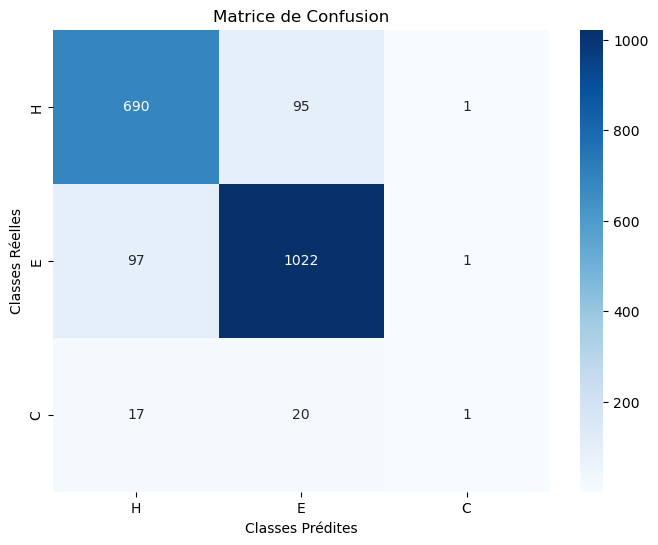

In [54]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Classes prédite avec la plus haute probabilité

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)

# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['H', 'E', 'C'], yticklabels=['H', 'E', 'C'])
plt.title('Matrice de Confusion')
plt.xlabel('Classes Prédites')
plt.ylabel('Classes Réelles')
plt.show()